In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.feature_selection import SelectPercentile 


In [2]:
# # Load Data from folds 1-4

# # Make sure the working directory is the same as the script

# files = glob.glob('negative_polarity/deceptive_from_MTurk/fold1/*.txt')
# files += glob.glob('negative_polarity/deceptive_from_MTurk/fold2/*.txt')
# files += glob.glob('negative_polarity/deceptive_from_MTurk/fold3/*.txt')
# files += glob.glob('negative_polarity/deceptive_from_MTurk/fold4/*.txt')


# deceptive = pd.DataFrame(columns=['text'])   
# for file in files:
#     with open(file, 'r') as f:
#             text = f.read()
#             deceptive = pd.concat([deceptive, pd.DataFrame({'text': [text]})], ignore_index=True)


# files = glob.glob('negative_polarity/truthful_from_Web/fold1/*.txt')
# files += glob.glob('negative_polarity/truthful_from_Web/fold2/*.txt')
# files += glob.glob('negative_polarity/truthful_from_Web/fold3/*.txt')
# files += glob.glob('negative_polarity/truthful_from_Web/fold4/*.txt')

# truthful = pd.DataFrame(columns=['text'])
# for file in files:
#     with open(file, 'r') as f:
#             text = f.read()
#             truthful = pd.concat([truthful, pd.DataFrame({'text': [text]})], ignore_index=True)

# deceptive['label'] = 0
# truthful['label'] = 1

# train = pd.concat([deceptive, truthful], ignore_index=True)

# files = glob.glob('negative_polarity/deceptive_from_MTurk/fold5/*.txt')
# deceptive_test = pd.DataFrame(columns=['text']) 
# for file in files:
#     with open(file, 'r') as f:
#             text = f.read()
#             deceptive_test = pd.concat([deceptive_test, pd.DataFrame({'text': [text]})], ignore_index=True)


# files = glob.glob('negative_polarity/truthful_from_Web/fold5/*.txt')
# truthful_test = pd.DataFrame(columns=['text'])
# for file in files:
#     with open(file, 'r') as f:
#             text = f.read()
#             truthful_test = pd.concat([truthful_test, pd.DataFrame({'text': [text]})], ignore_index=True)

# deceptive_test['label'] = 0
# truthful_test['label'] = 1

# test = pd.concat([deceptive_test, truthful_test], ignore_index=True)



In [3]:
# train.to_csv('train.csv', index=False)
# test.to_csv('test.csv', index=False)

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
all_models = {}

### BOW Unigrams No Normalisation

In [6]:
# Bag of words with unigrams
text_clf = Pipeline([
    ('vect', CountVectorizer())
])

X_train = text_clf.fit_transform(train['text'])
X_test = text_clf.transform(test['text'])

X_train = X_train.toarray()
X_test = X_test.toarray()

X_train = pd.DataFrame(X_train, columns=text_clf.named_steps['vect'].get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=text_clf.named_steps['vect'].get_feature_names_out())

y_train = train['label']
y_test = test['label']





In [ ]:
# Create Models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Tune hyperparameters
param_grid = {
    'Naive Bayes': {"alpha": [0.1, 0.5, 1]},
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'Decision Tree': {'max_depth': [1, 2, 5, 10, 100], 'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.5], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'max_depth': [1, 5, 10], 'n_estimators': [10, 100, 1000], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 5, 10]}
}

for model_name, model in models.items():
    print(f'Training {model_name}')
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5)
    grid_search.fit(X_train, y_train)
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best score: {grid_search.best_score_}')
    models[model_name] = grid_search.best_estimator_



SyntaxError: unterminated string literal (detected at line 14) (2062897391.py, line 14)

In [ ]:
from scipy.stats import chi2

from statsmodels.stats.contingency_tables import mcnemar
def mcnemar_test_models(preds1, preds2, y):
    # Generate predictions for both models
    
    # Calculate discordant pairs
    
    a = sum((preds1 == y) & (preds2 == y))  # Both models classify correctly
    b = sum((preds1 == y) & (preds2 != y))  # Model 1 misclassifies, model 2 classifies correctly
    c = sum((preds1 != y) & (preds2 == y))  # Model 1 classifies correctly, model 2 misclassifies
    d = sum((preds1 != y) & (preds2 != y))  # Both models misclassify
    
    m = [[a, b], [c, d]]
    return mcnemar(m)


In [ ]:
# Evaluate models
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
all_models["unigram-no-normalization"] = {}
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    result = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy_score(y_test, y_pred)],
        'Precision': [precision_score(y_test, y_pred)],
        'Recall': [recall_score(y_test, y_pred)],
        'F1': [f1_score(y_test, y_pred)]    
    })
    results = pd.concat([results, result], ignore_index=True)
    
    all_models["unigram-no-normalization"][model_name] = {}
    all_models["unigram-no-normalization"][model_name]["y_pred"] = y_pred.copy()
    all_models["unigram-no-normalization"][model_name]["model"] = model
    all_models["unigram-no-normalization"][model_name]["y_test"] = y_test.copy()
 
    
print(results)


                 Model  Accuracy  Precision  Recall        F1
0          Naive Bayes   0.89375   0.898734  0.8875  0.893082
1  Logistic Regression   0.83125   0.797753  0.8875  0.840237
2        Decision Tree   0.56250   0.555556  0.6250  0.588235
3        Random Forest   0.81250   0.828947  0.7875  0.807692


In [ ]:
# Feature importance
print('Feature Importance: Random Forest')
feature_importance_rf = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_rf['Feature'] = X_train.columns
feature_importance_rf['Importance'] = models['Random Forest'].feature_importances_
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)
print(feature_importance_rf.head(10))

print('\nFeature Importance: Decision Tree')
feature_importance_dt = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_dt['Feature'] = X_train.columns
feature_importance_dt['Importance'] = models['Decision Tree'].feature_importances_
feature_importance_dt = feature_importance_dt.sort_values(by='Importance', ascending=False)
print(feature_importance_dt.head(10))

Feature Importance: Random Forest
       Feature  Importance
1193   chicago    0.026837
4005        my    0.008107
3631  location    0.008058
6669       was    0.007088
5564     smell    0.006632
6699        we    0.006221
587         at    0.005936
4847  recently    0.005257
6111       the    0.005044
3065     hotel    0.004989

Feature Importance: Decision Tree
      Feature  Importance
1193  chicago    0.175349
510       are    0.031803
4091       no    0.031178
5400   sheets    0.029260
1505     cool    0.025480
6669      was    0.023124
3354       is    0.021381
6772  windows    0.019271
4005       my    0.018916
4117      not    0.017385


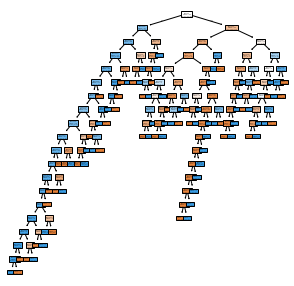

In [ ]:
# Plot DT
plt.figure(figsize=(5, 5))
plot_tree(models['Decision Tree'], filled=True, feature_names=X_train.columns)
plt.show()

### BOW Unigrams with Normalisation and Feature Selection

In [ ]:
# Bag of words with normalisation

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])

X_train = text_clf.fit_transform(train['text'])
X_test = text_clf.transform(test['text'])

X_train = X_train.toarray()
X_test = X_test.toarray()

X_train = pd.DataFrame(X_train, columns=text_clf.named_steps['vect'].get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=text_clf.named_steps['vect'].get_feature_names_out())

y_train = train['label']
y_test = test['label']

selector = SelectPercentile(percentile=10)
selector.fit(X_train, y_train)

X_train = X_train.loc[:, selector.get_support()]
X_test = X_test.loc[:, selector.get_support()]



In [ ]:

models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Tune hyperparameters

param_grid = {
    'Naive Bayes': {"alpha": [0.1, 0.5, 1]},
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'Decision Tree': {'max_depth': [1, 2, 5, 10, 100], 'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.5], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'max_depth': [1, 5, 10], 'n_estimators': [10, 100, 1000], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 5, 10]}
}

for model_name, model in models.items():
    print(f'Training {model_name}')
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5)
    grid_search.fit(X_train, y_train)
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best score: {grid_search.best_score_}')
    models[model_name] = grid_search.best_estimator_


Training Naive Bayes
Best parameters: {'alpha': 0.1}
Best score: 0.940625
Training Logistic Regression
Best parameters: {}
Best score: 0.8703125
Training Decision Tree
Best parameters: {}
Best score: 0.6796875
Training Random Forest
Best parameters: {}
Best score: 0.846875


In [ ]:
# Evaluate models

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
all_models["unigram-with-normalization"] = {}
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    result = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy_score(y_test, y_pred)],
        'Precision': [precision_score(y_test, y_pred)],
        'Recall': [recall_score(y_test, y_pred)],
        'F1': [f1_score(y_test, y_pred)]
    })
    results = pd.concat([results, result], ignore_index=True)
    all_models["unigram-with-normalization"][model_name] = {}
    all_models["unigram-with-normalization"][model_name]["y_pred"] = y_pred.copy()
    all_models["unigram-with-normalization"][model_name]["model"] = model
    all_models["unigram-with-normalization"][model_name]["y_test"] = y_test.copy()
 

print(results)


                 Model  Accuracy  Precision  Recall        F1
0          Naive Bayes   0.85000   0.818182   0.900  0.857143
1  Logistic Regression   0.83125   0.791209   0.900  0.842105
2        Decision Tree   0.70625   0.720000   0.675  0.696774
3        Random Forest   0.83125   0.819277   0.850  0.834356


In [ ]:
# Get feature importance
print('Feature Importance: Random Forest')
feature_importance_rf = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_rf['Feature'] = X_train.columns
feature_importance_rf['Importance'] = models['Random Forest'].feature_importances_
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)
print(feature_importance_rf.head(10))

print('\nFeature Importance: Decision Tree')
feature_importance_dt = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_dt['Feature'] = X_train.columns
feature_importance_dt['Importance'] = models['Decision Tree'].feature_importances_
feature_importance_dt = feature_importance_dt.sort_values(by='Importance', ascending=False)
print(feature_importance_dt.head(10))

Feature Importance: Random Forest
      Feature  Importance
110   chicago    0.066759
656       was    0.025640
74         be    0.020421
386        my    0.015952
668      when    0.013923
339  location    0.013826
294     hotel    0.013439
317        is    0.012080
407        of    0.010833
307        in    0.010802

Feature Importance: Decision Tree
        Feature  Importance
110     chicago    0.223415
386          my    0.047535
74           be    0.037233
630      turned    0.033942
268         had    0.033056
241       floor    0.032194
38          all    0.029881
612          to    0.027538
317          is    0.027321
140  conference    0.022231


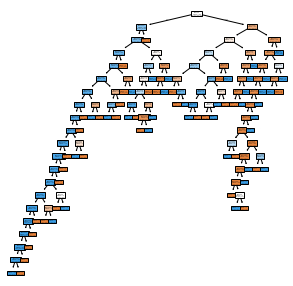

In [ ]:
# Plot DT
plt.figure(figsize=(5, 5))
plot_tree(models['Decision Tree'], filled=True, feature_names=X_train.columns)
plt.show()

### BOW With Bigrams No Normalisation

In [ ]:
# Bag of Words with bigrams

text_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2)))    
])

X_train = text_clf.fit_transform(train['text'])
X_test = text_clf.transform(test['text'])

X_train = X_train.toarray()
X_test = X_test.toarray()

X_train = pd.DataFrame(X_train, columns=text_clf.named_steps['vect'].get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=text_clf.named_steps['vect'].get_feature_names_out())

y_train = train['label']
y_test = test['label']

In [ ]:
# Tune hyperparameters

param_grid = {
    'Naive Bayes': {"alpha": [0.1, 0.5, 1]},
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'Decision Tree': {'max_depth': [1, 2, 5, 10, 100], 'ccp_alpha': [0.0, 0.1, 0.3, 0.5], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'max_depth': [1, 5, 10], 'n_estimators': [10, 100, 1000], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 5, 10]}
    }

for model_name, model in models.items():
    print(f'Training {model_name}')
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5)
    grid_search.fit(X_train, y_train)
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best score: {grid_search.best_score_}')
    models[model_name] = grid_search.best_estimator_
    



Training Naive Bayes
Best parameters: {'alpha': 0.1}
Best score: 0.8328125
Training Logistic Regression
Best parameters: {}
Best score: 0.8515625
Training Decision Tree
Best parameters: {}
Best score: 0.659375
Training Random Forest
Best parameters: {}
Best score: 0.771875


In [ ]:
# Evaluate models

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
all_models["bigram-no-normalization"] = {}


for model_name, model in models.items():
    y_pred = model.predict(X_test)
    result = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy_score(y_test, y_pred)],
        'Precision': [precision_score(y_test, y_pred)],
        'Recall': [recall_score(y_test, y_pred)],
        'F1': [f1_score(y_test, y_pred)],
    })
    results = pd.concat([results, result], ignore_index=True)
    all_models["bigram-no-normalization"][model_name] = {}
    all_models["bigram-no-normalization"][model_name]["y_pred"] = y_pred.copy()
    all_models["bigram-no-normalization"][model_name]["model"] = model
    all_models["bigram-no-normalization"][model_name]["y_test"] = y_test.copy()
 

In [ ]:
# Feature importance
print('Feature Importance: Random Forest')
feature_importance_rf = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_rf['Feature'] = X_train.columns
feature_importance_rf['Importance'] = models['Random Forest'].feature_importances_
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)
print(feature_importance_rf.head(10))

print('\nFeature Importance: Decision Tree')
feature_importance_dt = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_dt['Feature'] = X_train.columns
feature_importance_dt['Importance'] = models['Decision Tree'].feature_importances_
feature_importance_dt = feature_importance_dt.sort_values(by='Importance', ascending=False)
print(feature_importance_dt.head(10))

Feature Importance: Random Forest
             Feature  Importance
9711         chicago    0.010076
5087          at the    0.004420
37226       recently    0.003819
26790       location    0.003519
23213     in chicago    0.003404
29484             my    0.003318
9777   chicago hotel    0.003193
29744        my room    0.003016
52744             we    0.002838
27321         luxury    0.002470

Feature Importance: Decision Tree
        Feature  Importance
9711    chicago    0.175349
4116        are    0.031803
40517    sheets    0.029260
11578      cool    0.025480
23495    in the    0.023195
51638       was    0.023124
30588        no    0.021240
17937  for room    0.020199
47322      this    0.019447
54443   windows    0.019271


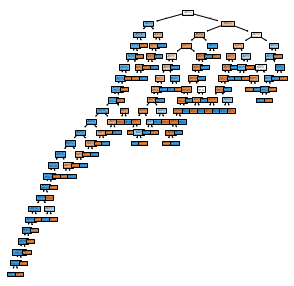

In [ ]:
# Plot DT
plt.figure(figsize=(5, 5))
plot_tree(models['Decision Tree'], filled=True, feature_names=X_train.columns)
plt.show()

### BOW Bigrams With Normalisation

In [ ]:
# Bag of Words with vectorised bigrams

text_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer())  
])

X_train = text_clf.fit_transform(train['text'])
X_test = text_clf.transform(test['text'])

X_train = X_train.toarray()
X_test = X_test.toarray()

X_train = pd.DataFrame(X_train, columns=text_clf.named_steps['vect'].get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=text_clf.named_steps['vect'].get_feature_names_out())

y_train = train['label']
y_test = test['label']

selector = SelectPercentile(percentile=2)
selector.fit(X_train, y_train)

X_train = X_train.loc[:, selector.get_support()]
X_test = X_test.loc[:, selector.get_support()]

In [ ]:
X_train.shape

(640, 1117)

In [ ]:
# Tune hyperparameters

param_grid = {
    'Naive Bayes': {"alpha": [0.1, 0.5, 1]},
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100, 250, 500]},
    'Decision Tree': {'max_depth': [1, 2, 5, 10, 100], 'ccp_alpha': [0.0, 0.1, 0.3, 0.5], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'max_depth': [1, 5, 10], 'n_estimators': [10, 100, 1000], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 5, 10]}}

for model_name, model in models.items():
    print(f'Training {model_name}')
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5)
    grid_search.fit(X_train, y_train)
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best score: {grid_search.best_score_}')
    models[model_name] = grid_search.best_estimator_



Training Naive Bayes
Best parameters: {'alpha': 0.1}
Best score: 0.96875
Training Logistic Regression
Best parameters: {}
Best score: 0.8703125
Training Decision Tree
Best parameters: {}
Best score: 0.6765625
Training Random Forest
Best parameters: {}
Best score: 0.8578125


In [ ]:
# Evaluate models

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
all_models["bigram-no-normalization"] = {}
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    result = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy_score(y_test, y_pred)],
        'Precision': [precision_score(y_test, y_pred)],
        'Recall': [recall_score(y_test, y_pred)],
        'F1': [f1_score(y_test, y_pred)]
    })
    results = pd.concat([results, result], ignore_index=True)
    all_models["bigram-with-normalization"][model_name] = {}
    all_models["bigram-with-normalization"][model_name]["y_pred"] = y_pred.copy()
    all_models["bigram-with-normalization"][model_name]["y_test"] = y_test.copy()
    all_models["bigram-with-normalization"][model_name]["model"] = model
 

print(results)

                 Model  Accuracy  Precision  Recall        F1
0          Naive Bayes   0.81250   0.804878  0.8250  0.814815
1  Logistic Regression   0.82500   0.851351  0.7875  0.818182
2        Decision Tree   0.68125   0.698630  0.6375  0.666667
3        Random Forest   0.78125   0.826087  0.7125  0.765101


In [ ]:
# Feature importance
print('Feature Importance: Random Forest')
feature_importance_rf = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_rf['Feature'] = X_train.columns
feature_importance_rf['Importance'] = models['Random Forest'].feature_importances_
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)
print(feature_importance_rf.head(10))

print('\nFeature Importance: Decision Tree')
feature_importance_dt = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_dt['Feature'] = X_train.columns
feature_importance_dt['Importance'] = models['Decision Tree'].feature_importances_
feature_importance_dt = feature_importance_dt.sort_values(by='Importance', ascending=False)
print(feature_importance_dt.head(10))

Feature Importance: Random Forest
       Feature  Importance
164    chicago    0.057821
1004       was    0.015936
542         my    0.015786
471   location    0.012622
96      at the    0.012526
92          at    0.011018
389      hotel    0.010524
766      smell    0.009286
292    finally    0.009267
113         be    0.008964

Feature Importance: Decision Tree
         Feature  Importance
164      chicago    0.208237
542           my    0.040486
92            at    0.035636
881    the staff    0.035005
969       turned    0.033791
257         east    0.032585
234      decided    0.029558
905    there are    0.026983
188  cleanliness    0.021552
59       and the    0.020754


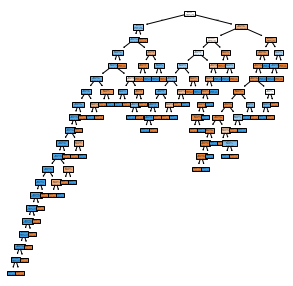

In [ ]:
# Plot DT
plt.figure(figsize=(5, 5))
plot_tree(models['Decision Tree'], filled=True, feature_names=X_train.columns)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from statsmodels.stats.contingency_tables import mcnemar

def mcnemar_test(preds1, preds2, y_test):
    # Generate predictions for both models
    
    # Calculate discordant pairs
    b = sum((preds1 == y_test) & (preds2 != y_test))  # Model 1 correct, Model 2 incorrect
    c = sum((preds1 != y_test) & (preds2 == y_test))  # Model 1 incorrect, Model 2 correct
    
    # Create contingency table
    table = [[0, b], [c, 0]]
    
    # Perform McNemar test
    result = mcnemar(table, exact=True)
    
    return result

# Example usage:
# result = mcnemar_test(trained_model1, trained_model2, X_test, y_test)
# print('McNemar test statistic:', result.statistic)
# print('p-value:', result.pvalue)

In [ ]:
import pickle
pickle.dump(all_models, open("all_models.p", "wb"))


In [ ]:
def find_best(all_models):
    best_model = None
    best_score = 0
    for key, value in all_models.items():
        print(key)
        y_pred = value['Logistic Regression']["y_pred"]
        #print(y_pred)
        score = accuracy_score(value['Logistic Regression']["y_test"], y_pred)
        #print(score)
        if score > best_score:
            best_score = score
            best_model = model
    return best_model, best_score

#print(all_models["unigram-no-normalization"])

#print(all_models)
print(find_best(all_models))

unigram-no-normalization
unigram-with-normalization
bigram-no-normalization
(RandomForestClassifier(), 0.83125)


In [ ]:
def mc_nemar_modela_to_modelb_same_data(models):
    results = {}
    for model_data_name, models_by_dataset in models.items():
        for model_name, model in models_by_dataset.items():
            for model_name2, model2 in models_by_dataset.items():
                if model_name == model_name2:
                    continue
                if (model_name2, model_name) in results:
                    continue
        #        print(model_name, model_name2)
         #       print(model)
                results[(model_data_name, model_name, model_name2)] = str(mcnemar_test(model["y_pred"], model2["y_pred"], model["y_test"]))
        
        #print(f'{model_name} confusion matrix')
        #print(confusion_matrix(y_test, y_pred))
       # print(f' mcnemar test between: {model_name} and {model_name2}')
        #(mcnemar_test(model, model2, X_test, y_test))
        #(mcnemar_test_models(model.predict(X_test), model2.predict(X_test), y_test))
       # print('\n')
    return results
def mc_nemar_dataa_to_datab_same_model(models):
    result = {}
    for model_data_name, models_by_dataset in models.items():
        for model_data_name2, models_by_dataset2 in models.items():
            if model_data_name == model_data_name2:
               continue
            for model_name, model in models_by_dataset.items():
                for model_name2, model2 in models_by_dataset2.items():
                    result[(model_name, model_data_name, model_data_name2)] = str(mcnemar_test(model["y_pred"], model2["y_pred"], model["y_test"]))
                   # print('\n')
    return result
print(mc_nemar_modela_to_modelb_same_data(all_models))
#print(mc_nemar_dataa_to_datab_same_model(all_models))


{('unigram-no-normalization', 'Naive Bayes', 'Logistic Regression'): 'pvalue      0.08715855330228806\nstatistic   9.0', ('unigram-no-normalization', 'Naive Bayes', 'Decision Tree'): 'pvalue      1.3280368233066496e-11\nstatistic   7.0', ('unigram-no-normalization', 'Naive Bayes', 'Random Forest'): 'pvalue      0.03508203336969018\nstatistic   10.0', ('unigram-no-normalization', 'Logistic Regression', 'Naive Bayes'): 'pvalue      0.08715855330228806\nstatistic   9.0', ('unigram-no-normalization', 'Logistic Regression', 'Decision Tree'): 'pvalue      6.027539034309403e-08\nstatistic   11.0', ('unigram-no-normalization', 'Logistic Regression', 'Random Forest'): 'pvalue      0.735878800856881\nstatistic   16.0', ('unigram-no-normalization', 'Decision Tree', 'Naive Bayes'): 'pvalue      1.3280368233066496e-11\nstatistic   7.0', ('unigram-no-normalization', 'Decision Tree', 'Logistic Regression'): 'pvalue      6.027539034309403e-08\nstatistic   11.0', ('unigram-no-normalization', 'Decision 